In [41]:
# Project specific modules
from src.pipeline import CleanYelpData

# The basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Spark library and functions
import pyspark as ps
import pyspark.sql.types as types
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import to_timestamp

# Sklearn Modeling
from sklearn.model_selection import train_test_split


# Surprise modeling
from surprise import SVD
import surprise
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Persistance
import pickle

# Housekeeping
from io import StringIO

# Spark Based Initial EDA

In [ ]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
# sc = spark.sparkContext

review_df = spark.read.json("data/review.json")
# checkin_df = spark.read.json("data/checkin.json")
# tip_df = spark.read.json("data/tip.json")
# user_df = spark.read.json("data/user.json")
business_df = spark.read.json("data/business.json")

In [12]:
# Count of distinct values for all fields in review_df:
this = business_df.agg(*(countDistinct(col(c)).alias(c) for c in business_df.columns))
this.show(1)

+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|  name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+
| 151977|     67875|     192609|     93385|1204|51566|      2|  155162|   150404|145046|      17541|        1184|    9|   36|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+



In [14]:
this = review_df.agg(*(countDistinct(col(c)).alias(c) for c in review_df.columns))
this.show(1)

+-----------+----+-------+-----+---------+-----+-------+------+-------+
|business_id|cool|   date|funny|review_id|stars|   text|useful|user_id|
+-----------+----+-------+-----+---------+-----+-------+------+-------+
|     192606| 201|6552820|  231|  6685900|    5|6668738|   289|1637138|
+-----------+----+-------+-----+---------+-----+-------+------+-------+



In [ ]:
bsubset_df = business_df.filter((business_df.categories.like('%Restaurants%')) &
                                (business_df.state == 'AZ')                               
                               )
print('There are {} Arizona restaurants in the dataset.'.format(bsubset_df.count()))

### Which region should we select for proceeding with this study? 

Let's look at the densities to decide:

In [ ]:
def calculate_region_density(state, businesses, bus_reviews):
    num_businesses = businesses.filter((businesses.categories.like('%Restaurants%')) &
                                (business_df.state == state)).count()
    num_reviews = bus_reviews.filter((bus_reviews.categories.like('%Restaurants%')) &
                                (bus_reviews.state == state)).count()
    return num_reviews/num_businesses

def compare_region_densities(regions, businesses, bus_reviews):
    max_density = 0
    density_dict = {}
    for region in regions:
        density = calculate_region_density(region, businesses, bus_reviews)
        density_dict[region] = density
        if density > max_density:
            max_density = density
            max_region = region

    print('Best Region: {}\nBest Density: {}'.format(max_region, max_density))
    return density_dict

In [ ]:
regions = ['AZ', 'ON', 'NC', 'AB', 'NV', 'OH', 'PA', 'IL', 'SC', 'QC']

density_dict = compare_region_densities(regions, business_df, bus_review_df)

pd.DataFrame.from_dict(density_dict, orient = 'index').sort_values(0, ascending = False).plot.bar(legend = False, figsize = (10, 6))
plt.ylabel('Review Density')
plt.xlabel('Region')
plt.title('Review Density by Region')

## Major Metros in Dataset
#### Las Vegas
* Henderson
#### Toronto
* Missassauga
* Markham
* North York
#### Phoenix - 56,686
* Mesa
* Tempe
* Scottsdale
* Chandler
* Glendale
* Gilbert
* Peoria
* Surprise
#### Calgary
#### Pittsburgh
#### Montreal
#### Cleveland
#### Madison, WI
#### Champaign, IL

## The winner: Arizona

We are proceeding with Arizona based businesses for this case study. Although Nevada has a greater density of reviews/restaurant, this data scientist considers it to be an anomaly in the restaurant space as well as user space given the impact tourism would have on restaurant visits/reviews. Arizona has the next highest density, would be expected to include a healthy mix of resident and non-resident reviews, most reviews are concentrated around Phoenix, and we would expect Phoenix to have a diverse group of users.

# Further EDA

Let's go ahead and pare the data down to reviews for restaurants in our area of interest so we can work in Pandas. To deal with the issue of running out of memory loading the entire dataset, the code below uses a project-specific class to read the data in chunks, identify the rows of interest, and then join the pertinent parts of all chunks together.

In [ ]:
# Load the data without spark but still accounting for low memory
pipe = CleanYelpData(use_spark=False, low_memory = True)
pipe.read_data()
bus_review_df = pipe.concatenate_chunks()

Alternatively, we can just load the data from a file created by the above process

In [147]:
bus_review_df = pd.read_pickle('data/bus_review_df.pkl')

In [148]:
bus_review_df.sample(1)

,business_id,cool,date,funny,review_id,review_stars,text,useful,user_id,address,categories,city,is_open,latitude,longitude,name,avg_stars,state
4158,evdJO0v9rvVixieNEnaeJg,0,2018-06-30 06:38:07,0,OVw5Wsj0xidF1YB_Tk_nrg,5,So good I had to come back two days later. Bes...,0,lI1s5clplzRqqxZ7a3hT_Q,3957 E Camelback Rd,"Sushi Bars, Japanese, Tapas/Small Plates, Rest...",Phoenix,1,33.50901,-111.995814,Sushiholic,4.5,AZ


Text(0, 0.5, 'Number of Restaurants (Log-scaled)')

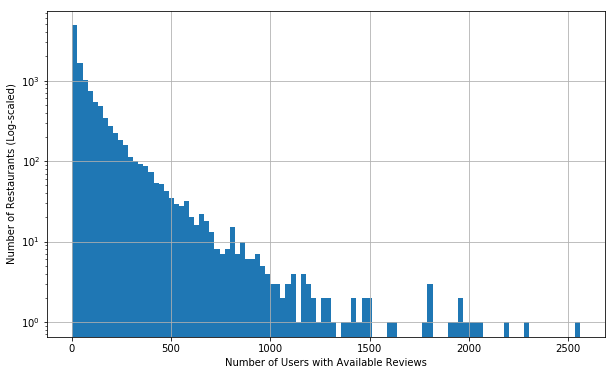

In [229]:
# What is the distribution of users per restaurant and ratings per user?
groups = bus_review_df.groupby('business_id')
ax = groups.user_id.nunique().hist(bins = 100, figsize = (10, 6))
ax.set_yscale('log')
ax.set_xlabel('Number of Users with Available Reviews')
ax.set_ylabel('Number of Restaurants (Log-scaled)')
# The number of users who reviewed each restaurant restaurant is exponentially distributed throughout
# the restaurants in AZ.

In [228]:
trimmed_bus_review_df = bus_review_df.groupby('business_id').user_id.nunique()
trimmed_bus_review_df
# Out of 11,465 restaurants in AZ
# 3419 have been reviewed by 100 or more users
# 7690 have been reviewed by 20 or more users
# 8405 have been reviewed by 15 or more users
# 9376 have been reviewed by 10 or more users (81% of restaurants)

business_id
--g-a85VwrdZJNf0R95GcQ      23
-01XupAWZEXbdNbxNg5mEg      99
-050d_XIor1NpCuWkbIVaQ     703
-092wE7j5HZOogMLAh40zA      92
-0Sgh0QlUKVsWosCWJzGqQ      47
-0WegMt6Cy966qlDKhu6jA     100
-0aIra_B6iALlfqAriBSYA      32
-0tgMGl7D9B10YjSN2ujLA     130
-1UMR00eXtwaeh59pEiDjA     412
-1VaIJza42Hjev6ukacCNg     210
-2A9emZwBK8zYHPnAmM0hw       9
-2isRNVb6PDuBagELL5EBw      24
-34vSRcMz_RjN00dWIiQ3Q      17
-3oxnPPPU3YoxO9M1I2idg     126
-3vXcKzJA_kVZDM8Yn3w_Q       4
-45kMvS7h38CGaWugPY0rg      90
-4TMQnQJW1yd6NqGRDvAeA     388
-4g68Hwm892_KPUuW5g1_Q      42
-4w2eZqQJcS-UNuB1lCPFA       5
-5brzniWtye3w__aEvCaAA       6
-6h3K1hj0d4DRcZNUtHDuw     521
-6tvduBzjLI1ISfs3F_qTg    1172
-79cl_yASWXiv7RmzirNxA      25
-7HB0UjguXW8csOH9svG4Q      46
-7d3UqQYYcBxbDH2do86sg      71
-8JaNeG3etLgOVyg2gOIiA      61
-8QlV3b_9H4BAh6LgMIr1g     480
-9eNGMp8XiygI8t8QFuFWw     316
-9nai28tnoylwViuJVrYEQ     491
-9xZZLLxuQabvBDODqpM-g      18
                          ... 
zqSfx9k2Pe33UDHmfa_fcg     

## Setting threshold to accept only restaurants reviewed by 10 or more users. So how many total users does that leave us with?

{'---94vtJ_5o_nikEs6hUjg': Int64Index([7898], dtype='int64'),
 '---PLwSf5gKdIoVnyRHgBA': Int64Index([1725], dtype='int64'),
 '---cu1hq55BP9DWVXXKHZg': Int64Index([15964, 18610], dtype='int64'),
 '--0LlX_UcypHnxW-4BUAdA': Int64Index([6257], dtype='int64'),
 '--1UpCuUDJQbqiuFXkOzaw': Int64Index([16932], dtype='int64'),
 '--1av6NdbEbMiuBr7Aup9A': Int64Index([10884], dtype='int64'),
 '--2HUmLkcNHZp0xw6AMBPg': Int64Index([13012,  1723,  2273, 14726,   162, 12790,  7842,  7212, 10246,
             16107, 17375, 13988,  3307,  6368,  9445,  1545, 14287, 11567,
              7034, 12560, 12650, 15859, 17621, 13574,  3290, 11476, 12834,
              5416, 17078,  1762, 12617,  9578, 13263, 10231, 13359, 17634,
              1228, 16737, 14412,  6818,  4300,  5696,   594, 13485, 14727,
             11802, 12340,  9993, 10904,  2186, 10438,  5285,   931,  2802,
              1831,  4210,  4417],
            dtype='int64'),
 '--3B8LdT1NCD-bPkwS5-5g': Int64Index([1763], dtype='int64'),
 '--3WaS23L

In [ ]:
# What time frame do these do these reviews span?

In [ ]:
# What about multiple reviews by one user? We should only take the latest...

In [ ]:
# Are there multiple reviews per user-restaurant?

In [ ]:
def calculate_density(df, numerator, denominator):
    '''
    Calculate density of one column to the other
    
    Params:
    ~~~~~~~~~
    df: type - Pandas Dataframe
    the dataframe holding the data from which you want to calculate the density
    numerator: type - string
    the name of the column that you want to find the density
    of with respect to some other column
    denominator: type - string
    the name of the column over which you want to calculate the density
    
    Example:
    # The density of users to businesses:
    calculate_density(df, df.user_id, df.business_id)
    '''
    num = len(df.groupby(numerator))
    den = len(df.groupby(denominator))
    density = num/den
    return density

calculate_density(bus_review_df, 'user_id', 'business_id')


# Explore modeling

In [6]:
# sample_df = pd.read_json('data/review_sample.json', lines = True)

In [62]:
# sample_df = pd.read_json('data/review_sample.json', lines = True)
# sample_df.drop(columns = ['cool', 'date', 'review_id',
#                         'funny', 'text', 'useful'], inplace = True)

In [144]:
# bus_review_df.drop(columns = ['cool', 'date', 'review_id',
#                         'funny', 'text', 'useful'], inplace = True)

In [77]:
pd.factorize(bus_review_df.business_id)[0]

array([   0,    0,    0, ..., 4101, 4101, 4101])

In [73]:
df = bus_review_df[['user_id', 'business_id', 'review_stars']]

y = df['review_stars']
X = df.drop('review_stars', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

identifier_df_train = X_train[['user_id', 'business_id']]
identifier_df_test = X_test[['user_id', 'business_id']]

In [74]:
# A reader is needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df, reader)

all_predictions = []
all_ratings = []

algs = [SVD(), surprise.SlopeOne(), surprise.NMF(),
                  surprise.NormalPredictor(), surprise.KNNBaseline(),
                  # surprise.KNNBasic(), surprise.KNNWithMeans(),
                  # surprise.KNNWithZScore(), surprise.BaselineOnly(),
                  surprise.CoClustering()]

# Iterate over all algorithms
for algorithm in algs:
    
    # Take a look at cross validation results to compare model types
    cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

    
#     # fit the model
#     alg_name = str(algorithm)[str(algorithm).find('ization')+8 : str(algorithm).find('obj')-1]
#     print('Fitting algorithm {}'.format(alg_name))
#     algorithm.fit(train_set)

#     # run predictions over
#     print('Predicting algorithm {}'.format(alg_name))
#     model_predictions = []
#     model_ratings = []
#     for idx, row in X_test.iterrows():
#         prediction = algorithm.predict(row[0], row[1])
#         model_predictions.append(prediction)
#         model_ratings.append(prediction[3])

#     # Pickle the models
#     pred_pkl_file = alg_name + '_predictions.pkl'
#     ratings_pkl_file = alg_name + '_ratings.pkl'
#     pickle.dump(model_predictions, open(pred_pkl_file, 'wb'))
#     pickle.dump(model_ratings, open(ratings_pkl_file, 'wb'))


KeyboardInterrupt: 